In [1]:
from foundry.util.runtime import setup
setup()
import jax
print("Devices:", jax.devices())

from image_diffusion.main import logger
logger.setLevel('INFO')

Devices: [CudaDevice(id=0)]


In [2]:
import foundry.random
import foundry.core.tree as tree
import foundry.numpy as npx
import foundry.train

from foundry.core.dataclasses import dataclass, replace

import foundry.core as F
import flax.linen as nn
import flax.linen.activation as activations

import rich
import jax
import optax
import foundry.train.console

import matplotlib.pyplot as plt
from typing import Sequence

In [21]:
color_map = {
    0: "#E52B50",
    1: "#9F2B68",
    2: "#3B7A57",
    3: "#3DDC84",
    4: "#FFBF00",
    5: "#915C83",
    6: "#008000",
    7: "#7FFFD4",
    8: "#E9D66B",
    9: "#007FFF",
}
def embed_scatter(zs, labels, **kwargs):
    colors = [color_map[label.item()] for label in labels]
    plt.scatter(zs[:, 0], zs[:, 1], c=colors, **kwargs)

def map(f, batch_size=None):
    return lambda *x: jax.lax.map(lambda x: f(*x), x, batch_size=batch_size)

def smoothed_colormesh(
        xs, ys, vals, val_clip=None, val_log=False, 
        t=None, t_max=None, t_min=None,

        **kwargs):
    if t is not None:
        max_mask = t <= t_max if t_max is not None else None
        min_mask = t >= t_min if t_min is not None else None
        mask = npx.logical_and(max_mask, min_mask) if max_mask is not None and min_mask is not None else \
            (max_mask if max_mask is not None else min_mask)
        if mask is not None:
            xs, ys, vals = xs[mask], ys[mask], vals[mask]

    x_min, x_max = npx.min(xs), npx.max(xs)
    y_min, y_max = npx.min(ys), npx.max(ys)
    xs_high = npx.linspace(x_min, x_max, 256)
    ys_high = npx.linspace(y_min, y_max, 256)
    x_bw, y_bw = (x_max - x_min)/32, (y_max - y_min)/32
    
    def eval(x, y):
        dists_sqr = (xs - x)**2/(x_bw**2) + (ys - y)**2/(y_bw**2)
        log_kernel = - dists_sqr
        log_kernel = log_kernel - jax.scipy.special.logsumexp(log_kernel)
        return npx.exp(jax.scipy.special.logsumexp(log_kernel, b=vals))
    XS_high, YS_high = npx.meshgrid(xs_high, ys_high)
    vals_high = map(map(eval, batch_size=4), batch_size=4)(XS_high, YS_high)
    if val_clip is not None:
        vals_high = vals_high.clip(-val_clip, val_clip)
    plt.scatter(xs, ys, c=vals, **kwargs)
    plt.pcolormesh(xs_high, ys_high, vals_high, **kwargs)

In [4]:
import wandb
api = wandb.Api()
artifact = api.artifact("dpfrommer-projects/image_diffusion/mnist-ddpm:v8")
checkpoint_url = artifact.get_entry("checkpoint.zarr.zip").ref
import foundry.util.serialize
checkpoint = foundry.util.serialize.load(checkpoint_url)

[13:46:08] INFO     image_diffusion - Learning T-SNE embedding...
[13:46:31] INFO     image_diffusion - Fit T-SNE embedding


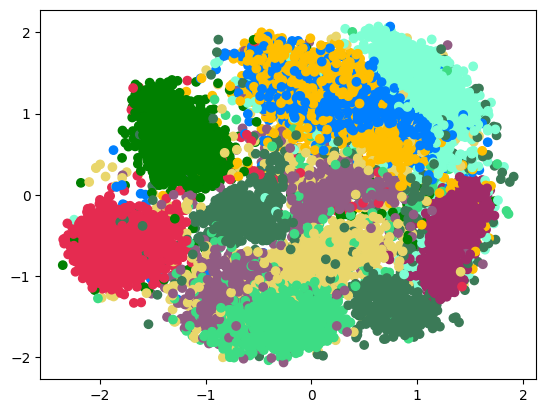

In [5]:
import jax
model = checkpoint.config.create()
schedule = checkpoint.schedule
vars = checkpoint.vars
normalizer, train_data, test_data = checkpoint.create_data()
train_data = jax.vmap(normalizer.normalize)(train_data.as_pytree())
test_data = jax.vmap(normalizer.normalize)(test_data.as_pytree())

latents = test_data.cond
embed_scatter(latents, test_data.label)

In [6]:
import foundry.diffusion.nonparametric as nonparametric
import functools

NUM_SAMPLES = 5_000
NW_SAMPLES_PER_COND = 512
SAMPLES_PER_COND = 4

@dataclass
class Evaluation:
    cond: jax.Array
    noised_y: jax.Array
    t: jax.Array
    out_nw: jax.Array | None = None
    out_model: jax.Array | None = None
    out_keypoints: jax.Array | None = None

@F.jit
def generate(vars, schedule, rng_key):
    cond_rng, samples_rng, nw_rng, eval_rng = foundry.random.split(rng_key, 4)
    cond = jax.random.uniform(cond_rng, (2,), minval=npx.min(test_data.cond,axis=0), maxval=npx.max(test_data.cond,axis=0))

    def sample(rng_key, N):
        def denoiser(rng_key, x, t):
            return model.apply(vars, x, t - 1, cond=cond)
        sample = lambda rng_key: schedule.sample(rng_key, denoiser, npx.zeros(test_data.data[0].shape))
        return jax.lax.map(sample, foundry.random.split(rng_key, N), batch_size=4)

    eval_samples = sample(samples_rng, SAMPLES_PER_COND)
    nw_samples = sample(nw_rng, NW_SAMPLES_PER_COND)

    def eval_sample(inputs):
        sample, rng_key = inputs
        n_rng, t_rng = jax.random.split(rng_key)
        # t = jax.random.randint(t_rng, (), minval=16, maxval=schedule.num_steps + 1)
        t = schedule.num_steps // 2
        noised_y, _, _ = schedule.add_noise(rng_key, sample, t)
        out_nw = schedule.output_from_denoised(
            noised_y, t,
            schedule.compute_denoised(noised_y, t, nw_samples)
        )
        return Evaluation(
            cond=cond,
            noised_y=noised_y,
            t=t,
            out_nw=out_nw,
        )
    eval_rngs = foundry.random.split(eval_rng, tree.axis_size(eval_samples, 0))
    return jax.lax.map(eval_sample, (eval_samples, eval_rngs))
generate = F.vmap(generate, in_axes=(None, None, 0))

batch_size = 64
eval_samples = []
rng = foundry.random.PRNGSequence(42)
num_batches = (NUM_SAMPLES//SAMPLES_PER_COND + batch_size - 1)//batch_size
for i in range(num_batches):
    logger.info(f"Sampling at condition {i*batch_size*SAMPLES_PER_COND} of {num_batches*SAMPLES_PER_COND*batch_size}")
    samples = generate(vars, schedule, foundry.random.split(next(rng), batch_size))
    eval_samples.append(tree.map(lambda x: npx.reshape(x, (x.shape[0]*x.shape[1],) + x.shape[2:]), samples))
logger.info("Done sampling")
eval_samples = tree.map(lambda *x: npx.concatenate(x, 0), *eval_samples)

[13:46:34] INFO     image_diffusion - Sampling at condition 0 of 5120


[13:47:48] INFO     image_diffusion - Sampling at condition 256 of 5120
[13:48:53] INFO     image_diffusion - Sampling at condition 512 of 5120
[13:49:59] INFO     image_diffusion - Sampling at condition 768 of 5120
[13:51:05] INFO     image_diffusion - Sampling at condition 1024 of 5120
[13:52:10] INFO     image_diffusion - Sampling at condition 1280 of 5120
[13:53:16] INFO     image_diffusion - Sampling at condition 1536 of 5120
[13:54:22] INFO     image_diffusion - Sampling at condition 1792 of 5120
[13:55:28] INFO     image_diffusion - Sampling at condition 2048 of 5120
[13:56:33] INFO     image_diffusion - Sampling at condition 2304 of 5120
[13:57:39] INFO     image_diffusion - Sampling at condition 2560 of 5120
[13:58:45] INFO     image_diffusion - Sampling at condition 2816 of 5120
[13:59:51] INFO     image_diffusion - Sampling at condition 3072 of 5120
[14:00:56] INFO     image_diffusion - Sampling at condition 3328 of 5120
[14:02:02] INFO     image_diffusion - Sampling at cond

In [7]:
NUM_KEYPOINTS = 64

keypoints = train_data.cond[:NUM_KEYPOINTS]
def eval(sample):
    out_model = model.apply(vars, sample.noised_y, sample.t - 1, cond=sample.cond)
    out_keypoints =jax.lax.map(lambda k: model.apply(vars, sample.noised_y, sample.t - 1, cond=k), keypoints)
    return replace(sample,
        out_model=out_model,
        out_keypoints=out_keypoints
    )
eval_samples = jax.lax.map(eval, eval_samples, batch_size=8)

In [8]:
test_out = model.apply(vars, eval_samples.noised_y[-1], eval_samples.t[-1] - 1, cond=eval_samples.cond[-1])
print(tree.axis_size(eval_samples, 0))
print(npx.mean(npx.square(test_out - eval_samples.out_model[-1])))

5120
8.61053e-08


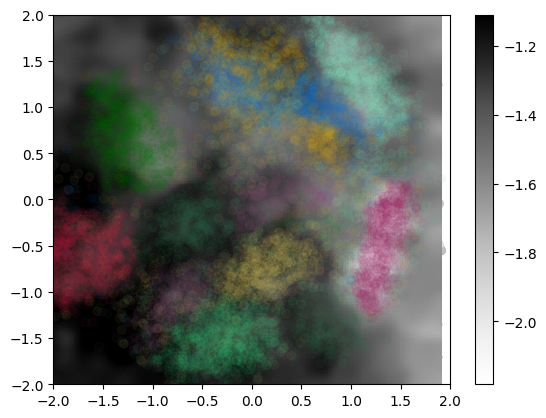

In [22]:
err = lambda val_a, val_b: npx.sqrt(npx.mean(npx.square(val_a - val_b)))
eval_cond = lambda val_a, val_b: npx.mean(F.vmap(err)(val_a, val_b))
errs = F.vmap(eval_cond)(eval_samples.out_model, eval_samples.out_nw)
smoothed_colormesh(
    eval_samples.cond[:,0], eval_samples.cond[:,1], errs, 
    val_clip=0.33,
    val_log=True,
    t=eval_samples.t,
    t_max=schedule.num_steps // 2, t_min=schedule.num_steps // 2,
    cmap="Greys")
plt.ylim(-2, 2)
plt.xlim(-2, 2)
#plt.scatter(eval_samples.cond[:,0], eval_samples.cond[:,1], c=errs.clip(0,0.5), cmap="Greys")
plt.colorbar()
embed_scatter(latents, test_data.label, alpha=0.04)

In [10]:
import foundry.train
import foundry.train.console
import flax.linen as nn
from foundry.train import LossOutput
from foundry.data import PyTreeData

USE_SOFTMAX = False
USED_KEYPOINTS = 32
USE_T = True
assert USED_KEYPOINTS <= keypoints.shape[0]


keypoint_model = KeypointModel()
keypoint_vars = keypoint_model.init(foundry.random.key(42),
    npx.zeros((2,)), npx.zeros((), dtype=npx.int32)
)
iterations = 10_000
optimizer = optax.adamw(optax.cosine_decay_schedule(4e-3, iterations))
opt_state = optimizer.init(keypoint_vars["params"])

@foundry.train.batch_loss
def loss_fn(keypoint_vars, rng_key, sample):
    alphas = keypoint_model.apply(keypoint_vars, sample.cond, sample.t)
    interpolated = alphas[:, None, None, None] * sample.out_keypoints[:USED_KEYPOINTS]
    interpolated = npx.sum(interpolated, axis=0)
    err = npx.mean(npx.square(interpolated - sample.out_model))
    return LossOutput(
        loss=err,
        metrics={"error": npx.sqrt(err)}
    )

with foundry.train.loop(
    PyTreeData(eval_samples).stream().shuffle(foundry.random.key(42)).batch(128),
    iterations=iterations,
    rng_key=foundry.random.key(42)
) as loop:
    for epoch in loop.epochs():
        for step in epoch.steps():
            opt_state, keypoint_vars, metrics = foundry.train.step(
                loss_fn, optimizer, opt_state=opt_state,
                vars=keypoint_vars, rng_key=step.rng_key,
                batch=step.batch
            )
            if step.iteration % 500 == 0:
                foundry.train.console.log(
                    step.iteration, metrics
                )

NameError: name 'KeypointModel' is not defined

Average error 0.06592249


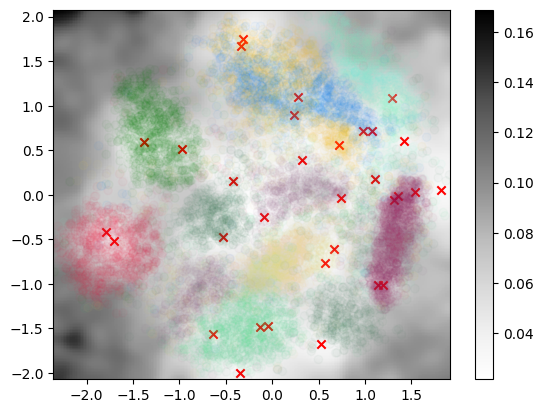

In [11]:
def eval(sample):
    alphas = keypoint_model.apply(keypoint_vars, sample.cond, sample.t)
    interpolated = alphas[:, None, None, None] * sample.out_keypoints[:USED_KEYPOINTS]
    interpolated = npx.sum(interpolated, axis=0)
    err = npx.sqrt(npx.mean(npx.square(interpolated - sample.out_model)))
    return err

keypoint_errs = map(eval, batch_size=256)(eval_samples)
print("Average error", npx.mean(keypoint_errs))

#plt.xlim(-0.15, 0)
#plt.ylim(-0.3,-0.2)
smoothed_colormesh(eval_samples.cond[:,0], eval_samples.cond[:,1], keypoint_errs, eval_samples.t,
                   t_min=0, t_max=32, cmap="Grays")
#plt.scatter(eval_samples.cond[:,0], eval_samples.cond[:,1], c=keypoint_errs, cmap="viridis")
plt.colorbar()
plt.scatter(keypoints[:USED_KEYPOINTS,0], keypoints[:USED_KEYPOINTS,1], c="red", marker="x")
embed_scatter(latents, test_data.label, alpha=0.03)

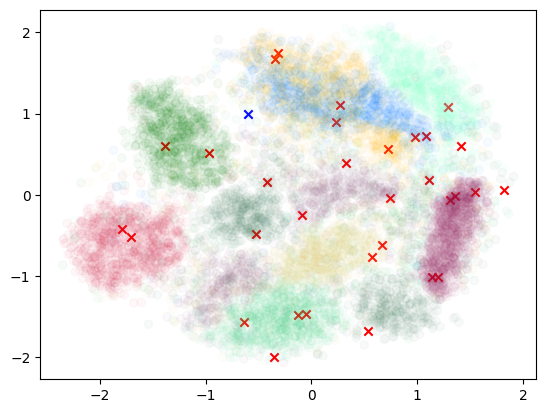

In [12]:
sampling_cond = npx.array([-0.6, 1.0])
plt.scatter(keypoints[:USED_KEYPOINTS,0], keypoints[:USED_KEYPOINTS,1], c="red", marker="x")
plt.scatter(sampling_cond[None,0], sampling_cond[None,1], c="blue", marker="x")
embed_scatter(latents, test_data.label, alpha=0.03)

In [22]:
import functools
import foundry.graphics
from IPython.display import display

from foundry.train import Image

@functools.partial(jax.jit, static_argnums=(0, 3,))
def sample_trajs(denoiser, cond, rng_key, N):
    def sample(rng_key):
        sample, traj = schedule.sample(rng_key, denoiser, npx.zeros(test_data.data[0].shape), trajectory=True)
        outputs = jax.lax.map(lambda s: denoiser(None, s[0], s[1]), (traj, npx.arange(1, 1 + traj.shape[0])))
        return sample, traj, outputs
    samples, trajs, outputs = jax.lax.map(sample, foundry.random.split(rng_key, N), batch_size=8)
    samples = (128*(samples+1)).astype(npx.uint8)
    return Image(foundry.graphics.image_grid(samples)), trajs, outputs

@functools.partial(jax.jit, static_argnums=(2,))
def nn_sample(cond, rng_key, N):
    def denoiser(rng_key, x, t):
        return model.apply(vars, x, t - 1, cond=cond)
    return sample_trajs(denoiser, cond, rng_key, N)

@functools.partial(jax.jit, static_argnums=(2,))
def linear_sample(cond, rng_key, N):
    def denoiser(rng_key, x, t):
        alphas = keypoint_model.apply(keypoint_vars, cond, t)
        out_keypoints = F.vmap(lambda k: model.apply(vars, x, t-1, cond=k))(keypoints[:USED_KEYPOINTS])
        interpolated = alphas[:, None, None, None] * out_keypoints
        interpolated = npx.sum(interpolated, axis=0)
        return interpolated
    return sample_trajs(denoiser, cond, rng_key, N)

nn_grid, nn_trajs, nn_outputs = nn_sample(sampling_cond, jax.random.key(42), 16)
lin_grid, lin_trajs, lin_outputs = linear_sample(sampling_cond, jax.random.key(42), 16)
display(nn_grid)
display(lin_grid)


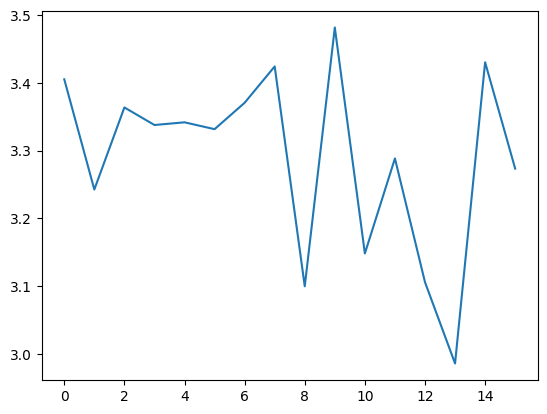

In [29]:
plt.plot(
    npx.arange(nn_outputs.shape[0]), 
    npx.linalg.norm(nn_outputs.reshape(16, -1) - lin_outputs.reshape(16, -1), axis=(-1))/16
)
plt.show()